# 1. The BlueiceExtendedModel: Rate and shape parameters
In this tutorial, we'll learn about the `BlueiceExtendedModel`, which is based on [blueice](https://github.com/JelleAalbers/blueice) likelihoods and dive into its rate and shape parameters.

## 1.1 Initializing the model

This statistical model has the same basic functionalities to `generate_data` and then `fit` the data. However, the likelihood is a bit more complex than in the previous example. Thus, the definition of the parameters and of the individual likelihood terms are conveniently defined in a YAML configuration file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from alea import BlueiceExtendedModel

In [2]:
# Just some plotting settings
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9

In this tutorial we'll use the example provided in `alea/alea/examples/configs/unbinned_wimp_statistical_model_simple.yaml` and we initialize the model from this file via the `.from_config()` method. You can have a look at the file but it's not really necessary for this tutorial and we'll go through it in more detail in the next one.

In [3]:
config_path = "unbinned_wimp_statistical_model_simple.yaml"
model = BlueiceExtendedModel.from_config(config_path)

Computing/loading models on one core: 100%|██████████| 5/5 [00:00<00:00, 345.57it/s]

Again, let's start by looking at which parameters we have defined in the model. Printing the `parameters` object will show us a table with all parameters and their attributes/properties. Especially the last column with the description can be helpful to understand the model:

In [4]:
print(model.parameters)

                      nominal_value  fittable  ptype  uncertainty relative_uncertainty    blueice_anchors fit_limits parameter_interval_bounds  fit_guess                                               description
wimp_mass                      50.0     False   None          NaN                 None               None       None                      None        NaN                                      WIMP mass in GeV/c^2
livetime                        2.0     False   None          NaN                 None               None       None                      None        NaN                                         Livetime in years
wimp_rate_multiplier            1.0      True   rate          NaN                 None               None  [0, None]                 [0, None]        NaN                                                      None
er_rate_multiplier              1.0      True   rate          0.2                 True               None  [0, None]                      None        1.

The model consists of a **WIMP signal component** (`wimp_mass`. `wimp_rate_multiplier`) and an **electronic recoil (ER) background** component (`er_rate_multiplier`, `er_band_shift`). In addition there is a parameter called `livetime`, which correspond to the exposure of the data acquisition period.

## 1.2 Generate Data

Before discussing rate and shape parameters, let's have a look at some data generated from the model:

In [5]:
data = model.generate_data()

In [6]:
data.keys()

dict_keys(['science_run', 'ancillary_likelihood', 'generate_values'])

The data is a dictionary containing data from the `science_run` and the `ancillary_likelihood`. It also contains the `generate_values`, which are tha values of the parameters used to generate the data. We'll discuss the `ancillary_likelihood` later and for now focus on the `science_run` data.

In [7]:
data["science_run"]

array([(99.06247482, 5118.70656921, 0), (65.50859027, 4150.54777077, 0),
       (70.85000965, 4260.18698092, 0), (81.71831   , 5692.4399723 , 0),
       (38.53968294, 2998.71589099, 0), (72.81325674, 4646.35403571, 0),
       (24.66886233, 3637.66976735, 0), (45.44804407, 3805.40533947, 0),
       (32.03707821, 2513.64777614, 0), (72.53205965, 4272.38687062, 0),
       (76.98417452, 4569.78542611, 0), (87.95290778, 3996.97194225, 0),
       (27.62853794, 2660.01143741, 0), (54.84087   , 3989.57248821, 0),
       (53.9255403 , 3368.58012133, 0), (27.30362987, 2749.23034895, 0),
       (36.6516434 , 2385.40286704, 0), (31.09971809, 3424.30705957, 0),
       (35.29093196, 2807.12068438, 0), (49.36018646, 3854.30983539, 0),
       (18.20395797, 2143.09548685, 0), (39.88265627, 2665.17257144, 0),
       (43.82593679, 2963.76328973, 0), (35.62651498, 3401.4646717 , 0),
       (57.99852381, 3136.3983665 , 0), (18.68920226, 2404.55209482, 0),
       (55.51776497, 3247.5517995 , 0), (48.2797672

We see that the data has entries `cs1`, `cs2`, and `source`. S1 and S2 are the prompt scintillation and delayed signal from drifted electrons, respectively. The "c" in front denotes that those are corrected for detector effects. The key `source` refers to the origin of each event. It is the index of the source name list, which we can look up with the `get_source_name_list` method:

In [8]:
source_name_list = model.get_source_name_list(likelihood_name="science_run")
source_name_list

['er', 'wimp']

Let's have a look at the toy data:

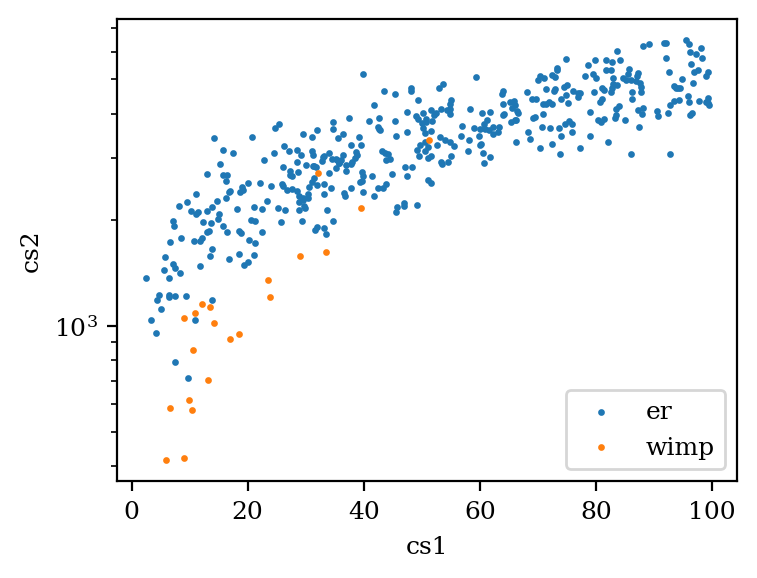

In [9]:
for i, source_name in enumerate(source_name_list):
    mask = data["science_run"]["source"] == i
    plt.scatter(
        data["science_run"]["cs1"][mask], data["science_run"]["cs2"][mask], label=source_name, s=2
    )
plt.xlabel("cs1")
plt.ylabel("cs2")
plt.semilogy()
plt.legend(loc="lower right")

Most WIMP events have lower values of `cs1` and `cs2` compared to the ER events. We can use this to discriminate WIMP signal events from ER background events.

## 1.3 Rate parameters and shape parameters

Blueice distinguished between *rate parameters*, which only scale the expectation value of the respective component, and *shape parameters*, which also change the shape of the component. The only shape parameter used here is the `er_band_shift`, which shifts the ER band in the two dimensional parameter space. To illustrate this, let's look at some toy data:

The rate parameters simply linearly scale the expectation values of each component of the model. Their nominal values are 1.0, which gives the following expectation values for the defined livetime:

In [10]:
model.get_expectation_values()

{'er': 400.0, 'wimp': 20.0}

We can verify that this is roughly what we observed in the data:

In [11]:
for i, source_name in enumerate(source_name_list):
    mask = data["science_run"]["source"] == i
    print(f"Source {source_name} has {np.sum(mask)} events.")

Source er has 418 events.
Source wimp has 21 events.


If we choose a `wimp_rate_multiplier` of 10 we should thus see a 10-fold increase of the expected number of WIMP events:

In [12]:
model.get_expectation_values(wimp_rate_multiplier=10.0)

{'er': 400.0, 'wimp': 200.0}

In [13]:
wimp_rich_data = model.generate_data(wimp_rate_multiplier=10.0)
for i, source_name in enumerate(source_name_list):
    mask = wimp_rich_data["science_run"]["source"] == i
    print(f"Source {source_name} has {np.sum(mask)} events.")

Source er has 381 events.
Source wimp has 201 events.


Now let's see what the shape parameters do. We generate a toy dataset the nominal and the two extreme values of the `er_band_shift` parameter and see what this does to the data:

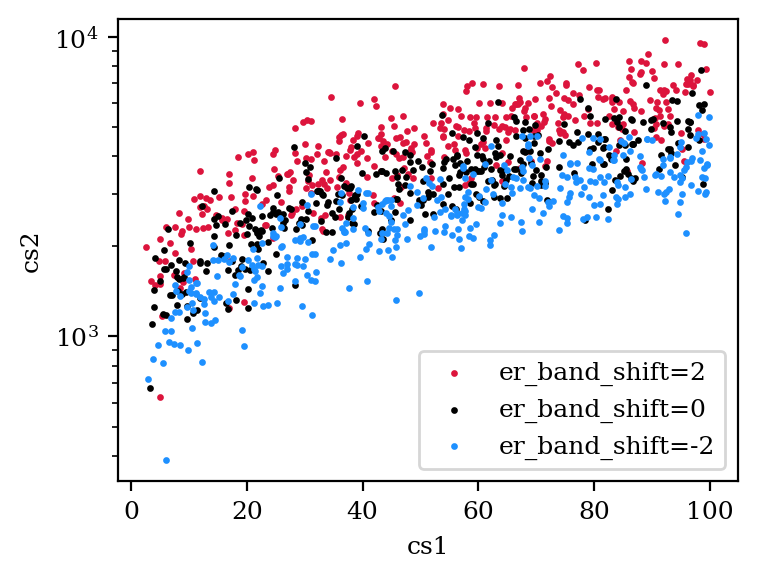

In [14]:
for er_band_shift, c in zip([2, 0, -2], ["crimson", "k", "dodgerblue"]):
    data = model.generate_data(er_band_shift=er_band_shift)
    mask = data["science_run"]["source"] == source_name_list.index("er")
    plt.scatter(
        data["science_run"]["cs1"][mask],
        data["science_run"]["cs2"][mask],
        label=f"er_band_shift={er_band_shift}",
        c=c,
        s=2,
    )
plt.xlabel("cs1")
plt.ylabel("cs2")
plt.semilogy()
plt.legend(loc="lower right")

As you can see, the parameter `er_band_shift` moves the ER band up and down in log(cs2).